In [20]:
# - Data processing
import numpy as np

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

# - Import modules
from rockpool.devices.xylo.imu.preprocessing import (
    Quantizer,
    RotationRemoval,
    FilterBank,
    ScaleSpikeEncoder,
    IAFSpikeEncoder,
)
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent


## Get the data sample

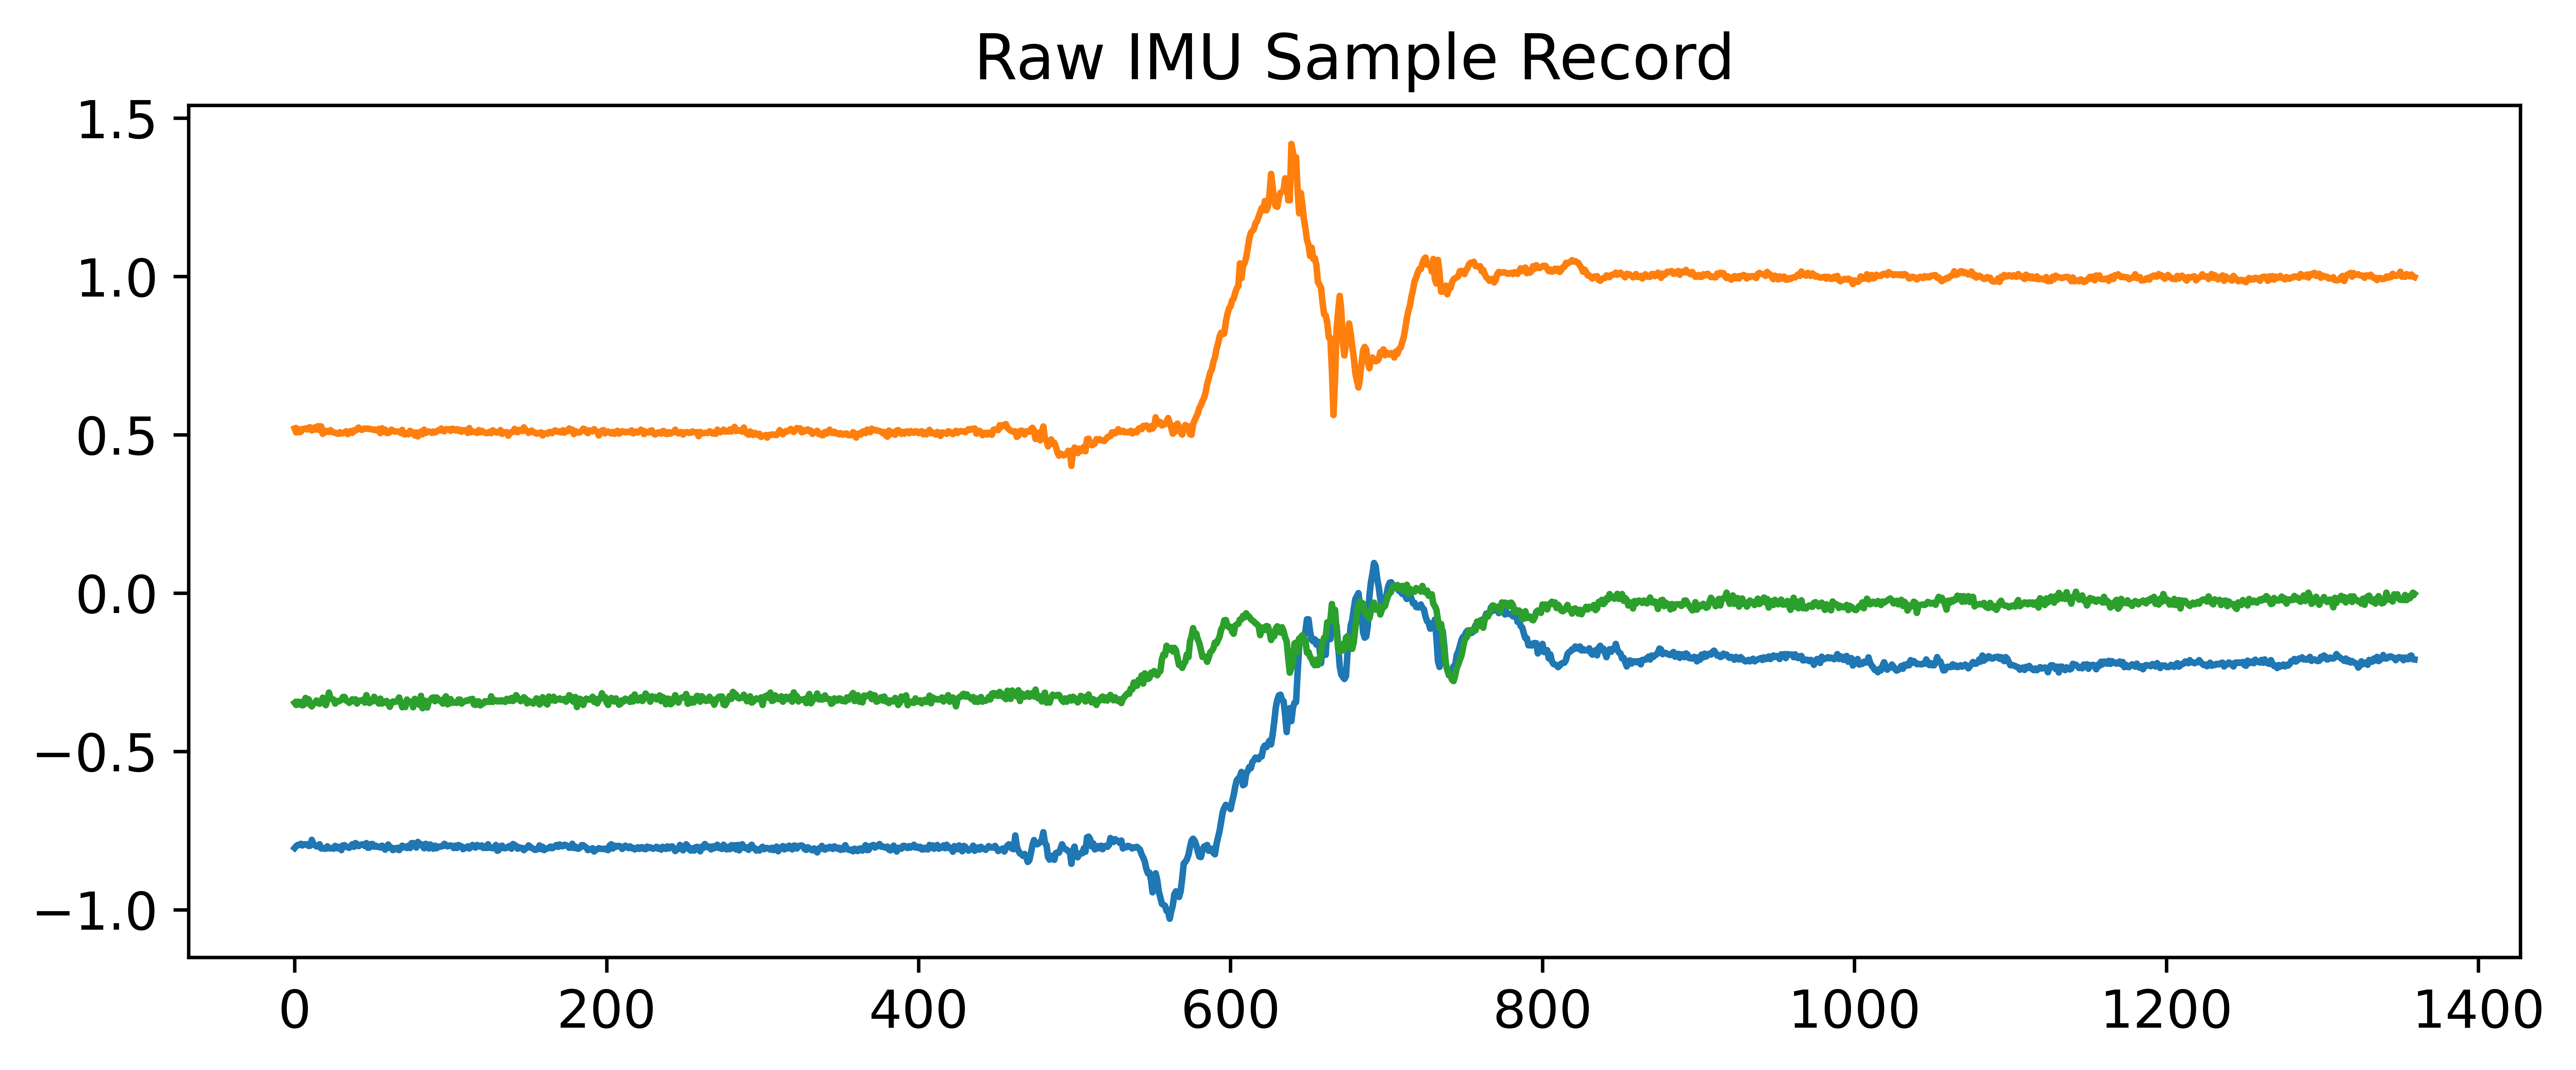

In [21]:
with open("data.npy", "rb") as f:
    data = np.load(f)

plt.figure()
plt.plot(data)
plt.title(f"Raw IMU Sample Record")
plt.show()


In [22]:
data.shape


(1360, 3)

## Step 1 : Quantize the data

Scale is obtained by investigating the dataset statistics. The maximum amplitude = 1.0 using scale factor=`0.49`

In [23]:
num_bits_in = 16
quantizer = Quantizer(shape=3, scale=0.49, num_bits=num_bits_in)


In [24]:
data_quantized, _, _ = quantizer(data)
data_quantized.shape


(1, 1360, 3)

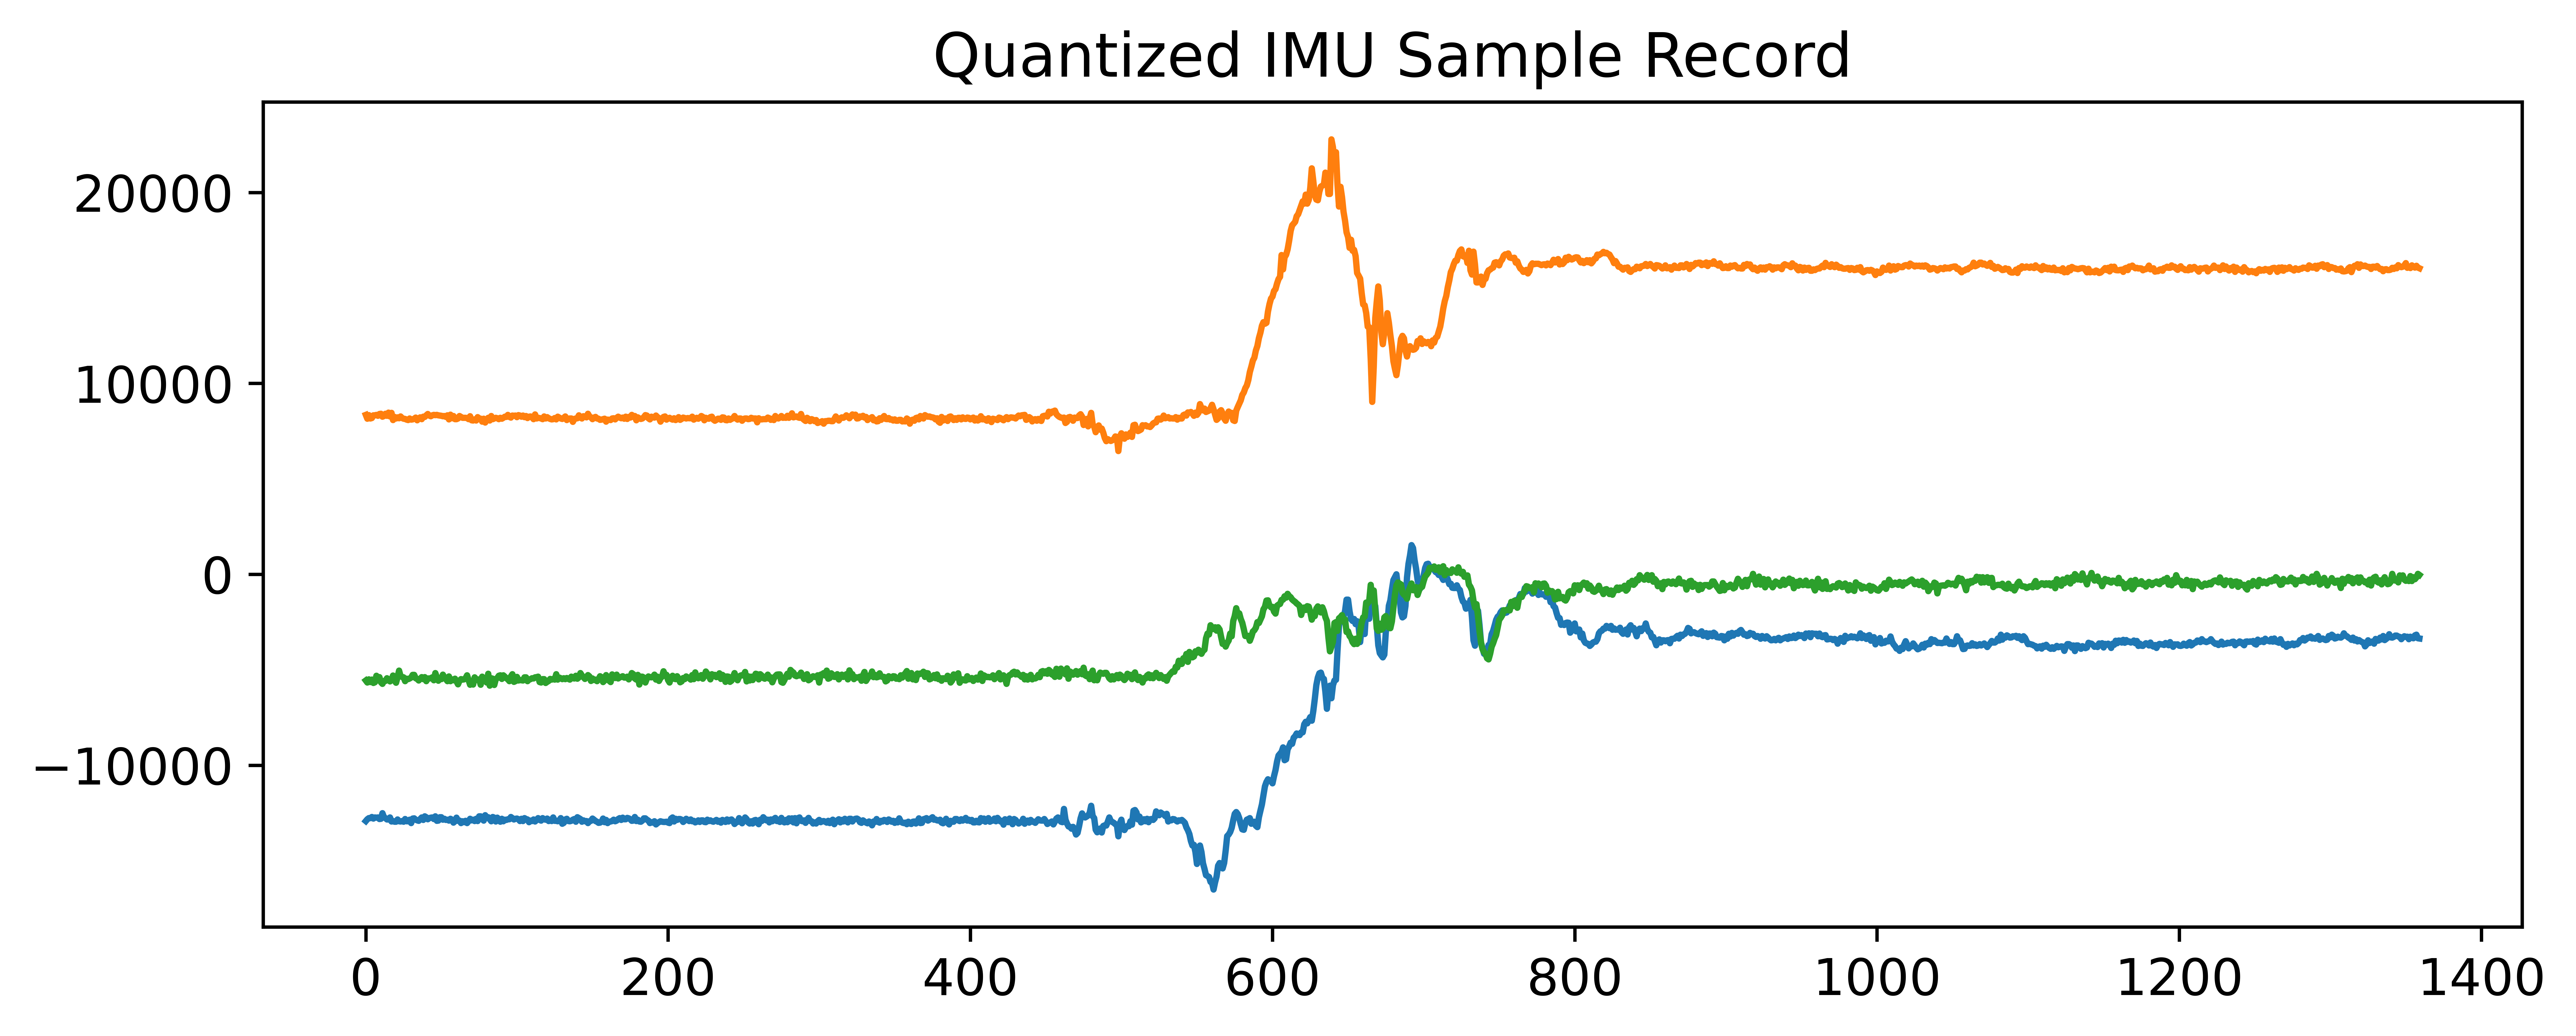

In [25]:
plt.figure()
plt.plot(data_quantized[0])
plt.title(f"Quantized IMU Sample Record")
plt.show()


## Step 2 : Rotation Removal

In [26]:
# create a rotation removal module
num_avg_bitshift = 4
sampling_period = 10

rot_removal = RotationRemoval(
    num_avg_bitshift=num_avg_bitshift,
    sampling_period=sampling_period,
)


In [27]:
data_normalized, _, _ = rot_removal(data_quantized)

# Sign correction
correction_factor = np.sign(data_normalized) * np.sign(data)
data_normalized = data_normalized * correction_factor
data_normalized = data_normalized.astype(np.int64).astype(object)
data_normalized.shape


(1, 1360, 3)

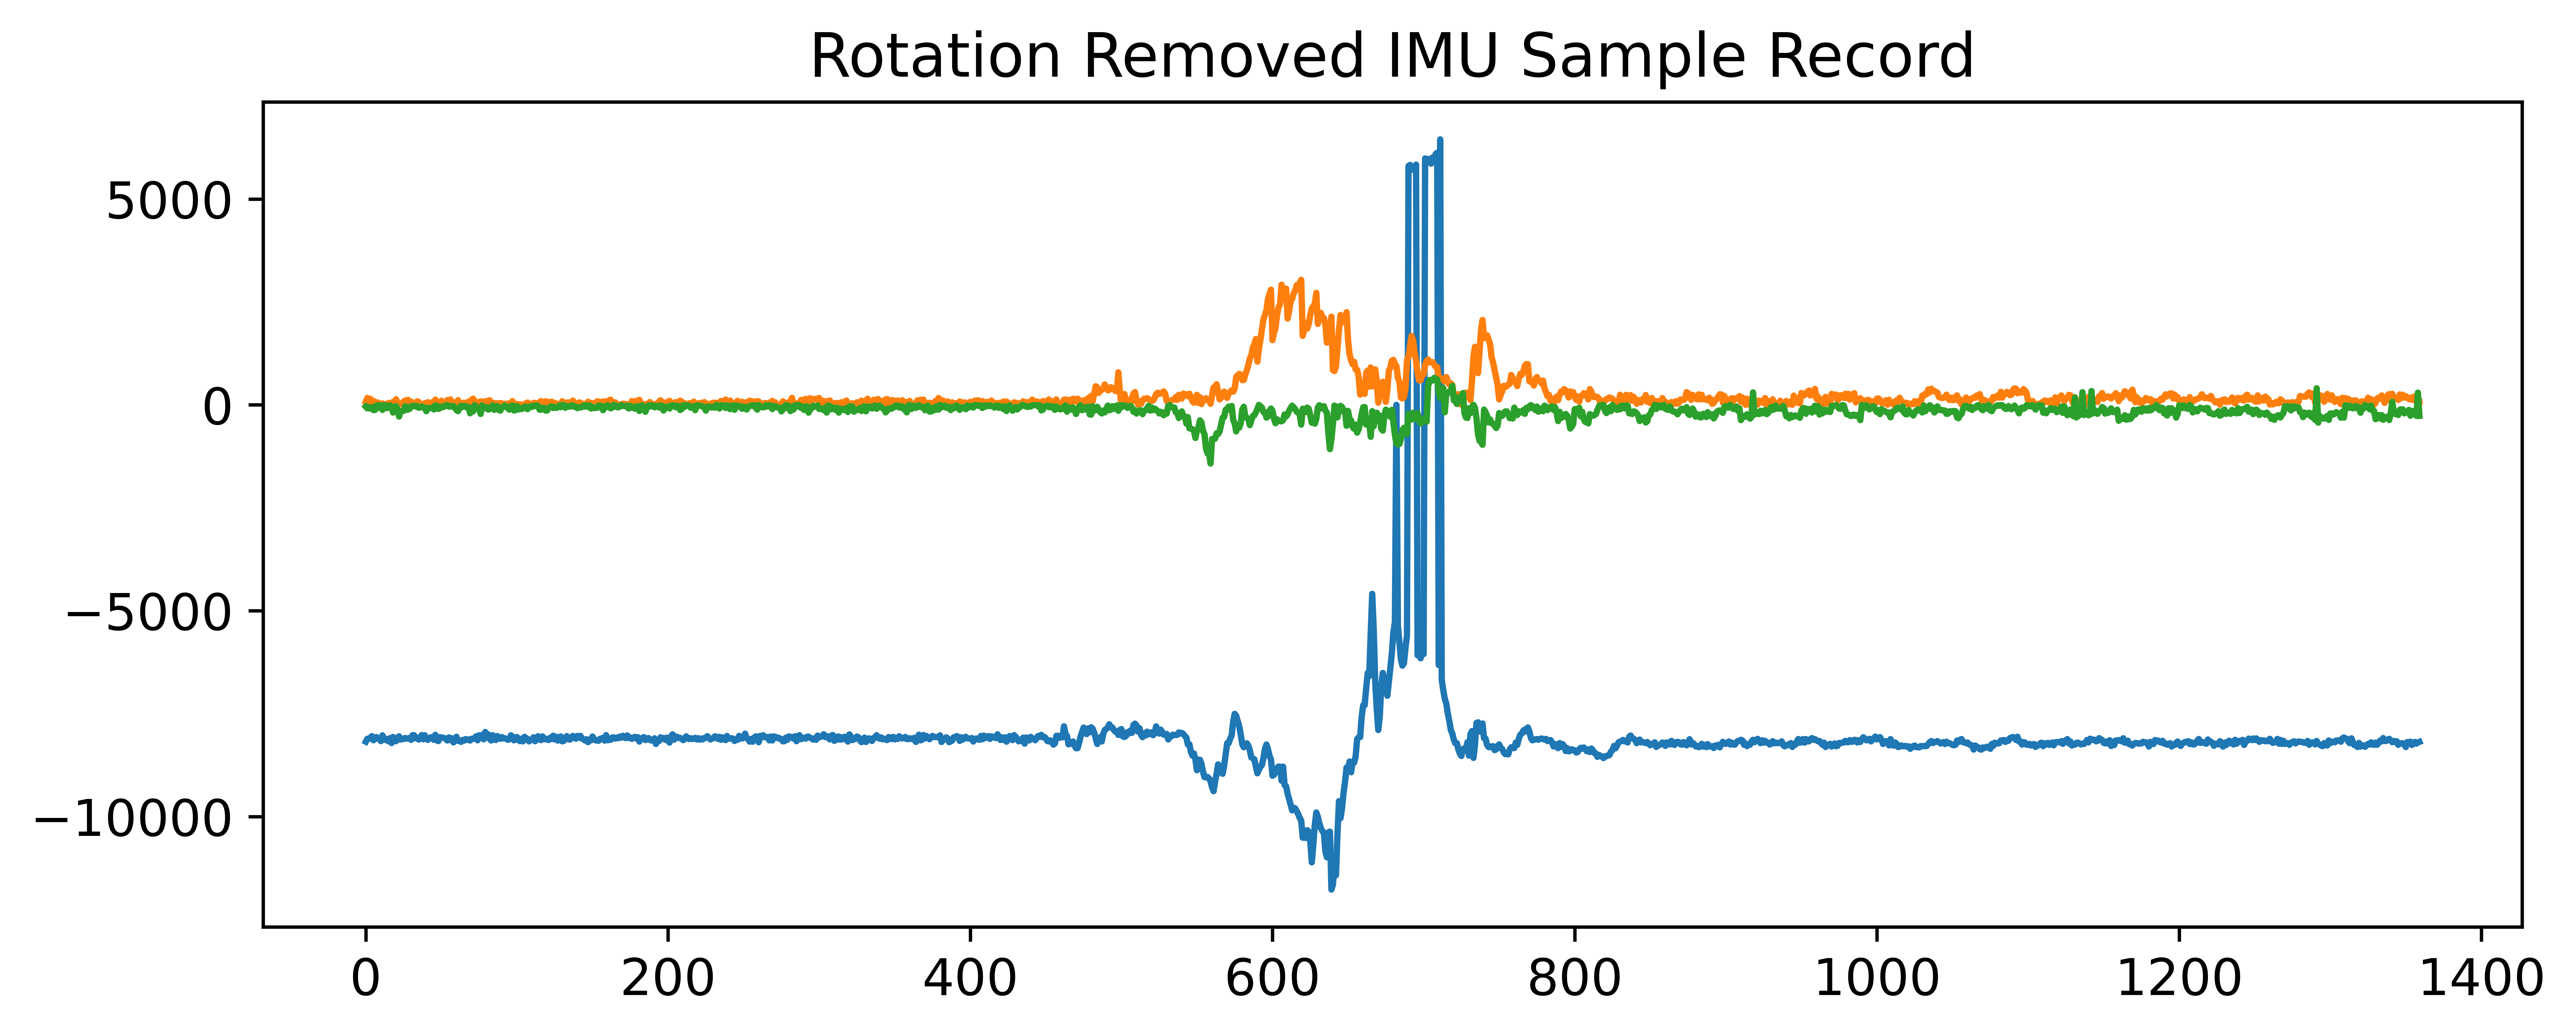

In [28]:
plt.figure()
plt.plot(data_normalized[0])
plt.title(f"Rotation Removed IMU Sample Record")
plt.show()


## Step 3 : Filtering

In [29]:
filterbank = FilterBank()


In [30]:
filtered, _, _ = filterbank(data_normalized)
filtered.shape


(1, 1360, 15)

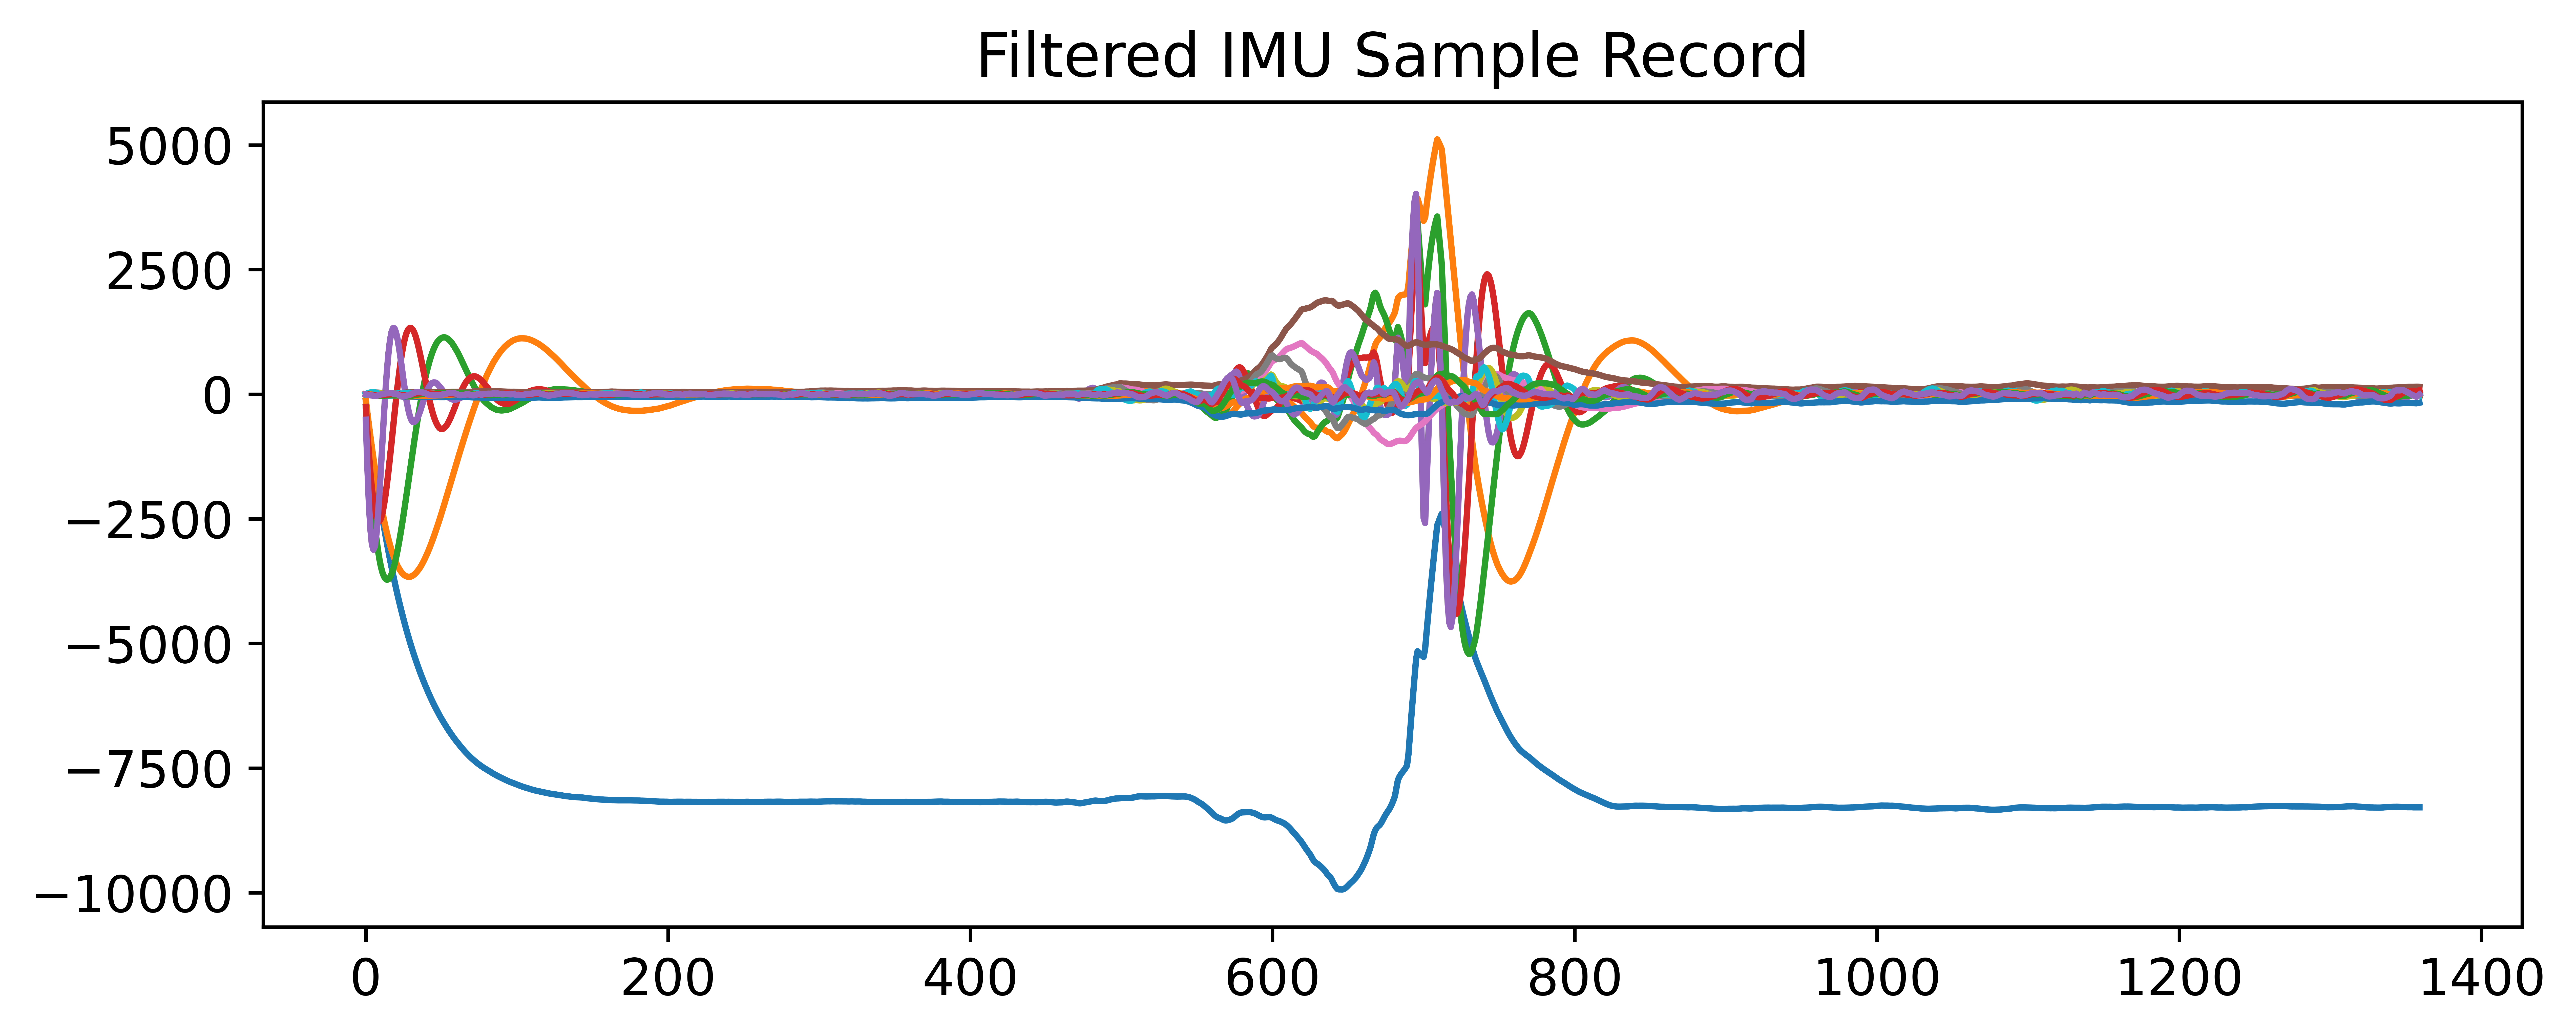

In [31]:
plt.figure()
plt.plot(filtered[0])
plt.title(f"Filtered IMU Sample Record")
plt.show()


## Step 4 : Spike Encoding

In [32]:
scale_encoder = ScaleSpikeEncoder()
scaled, _, _ = scale_encoder(filtered)
scaled.shape


(1, 1360, 15)

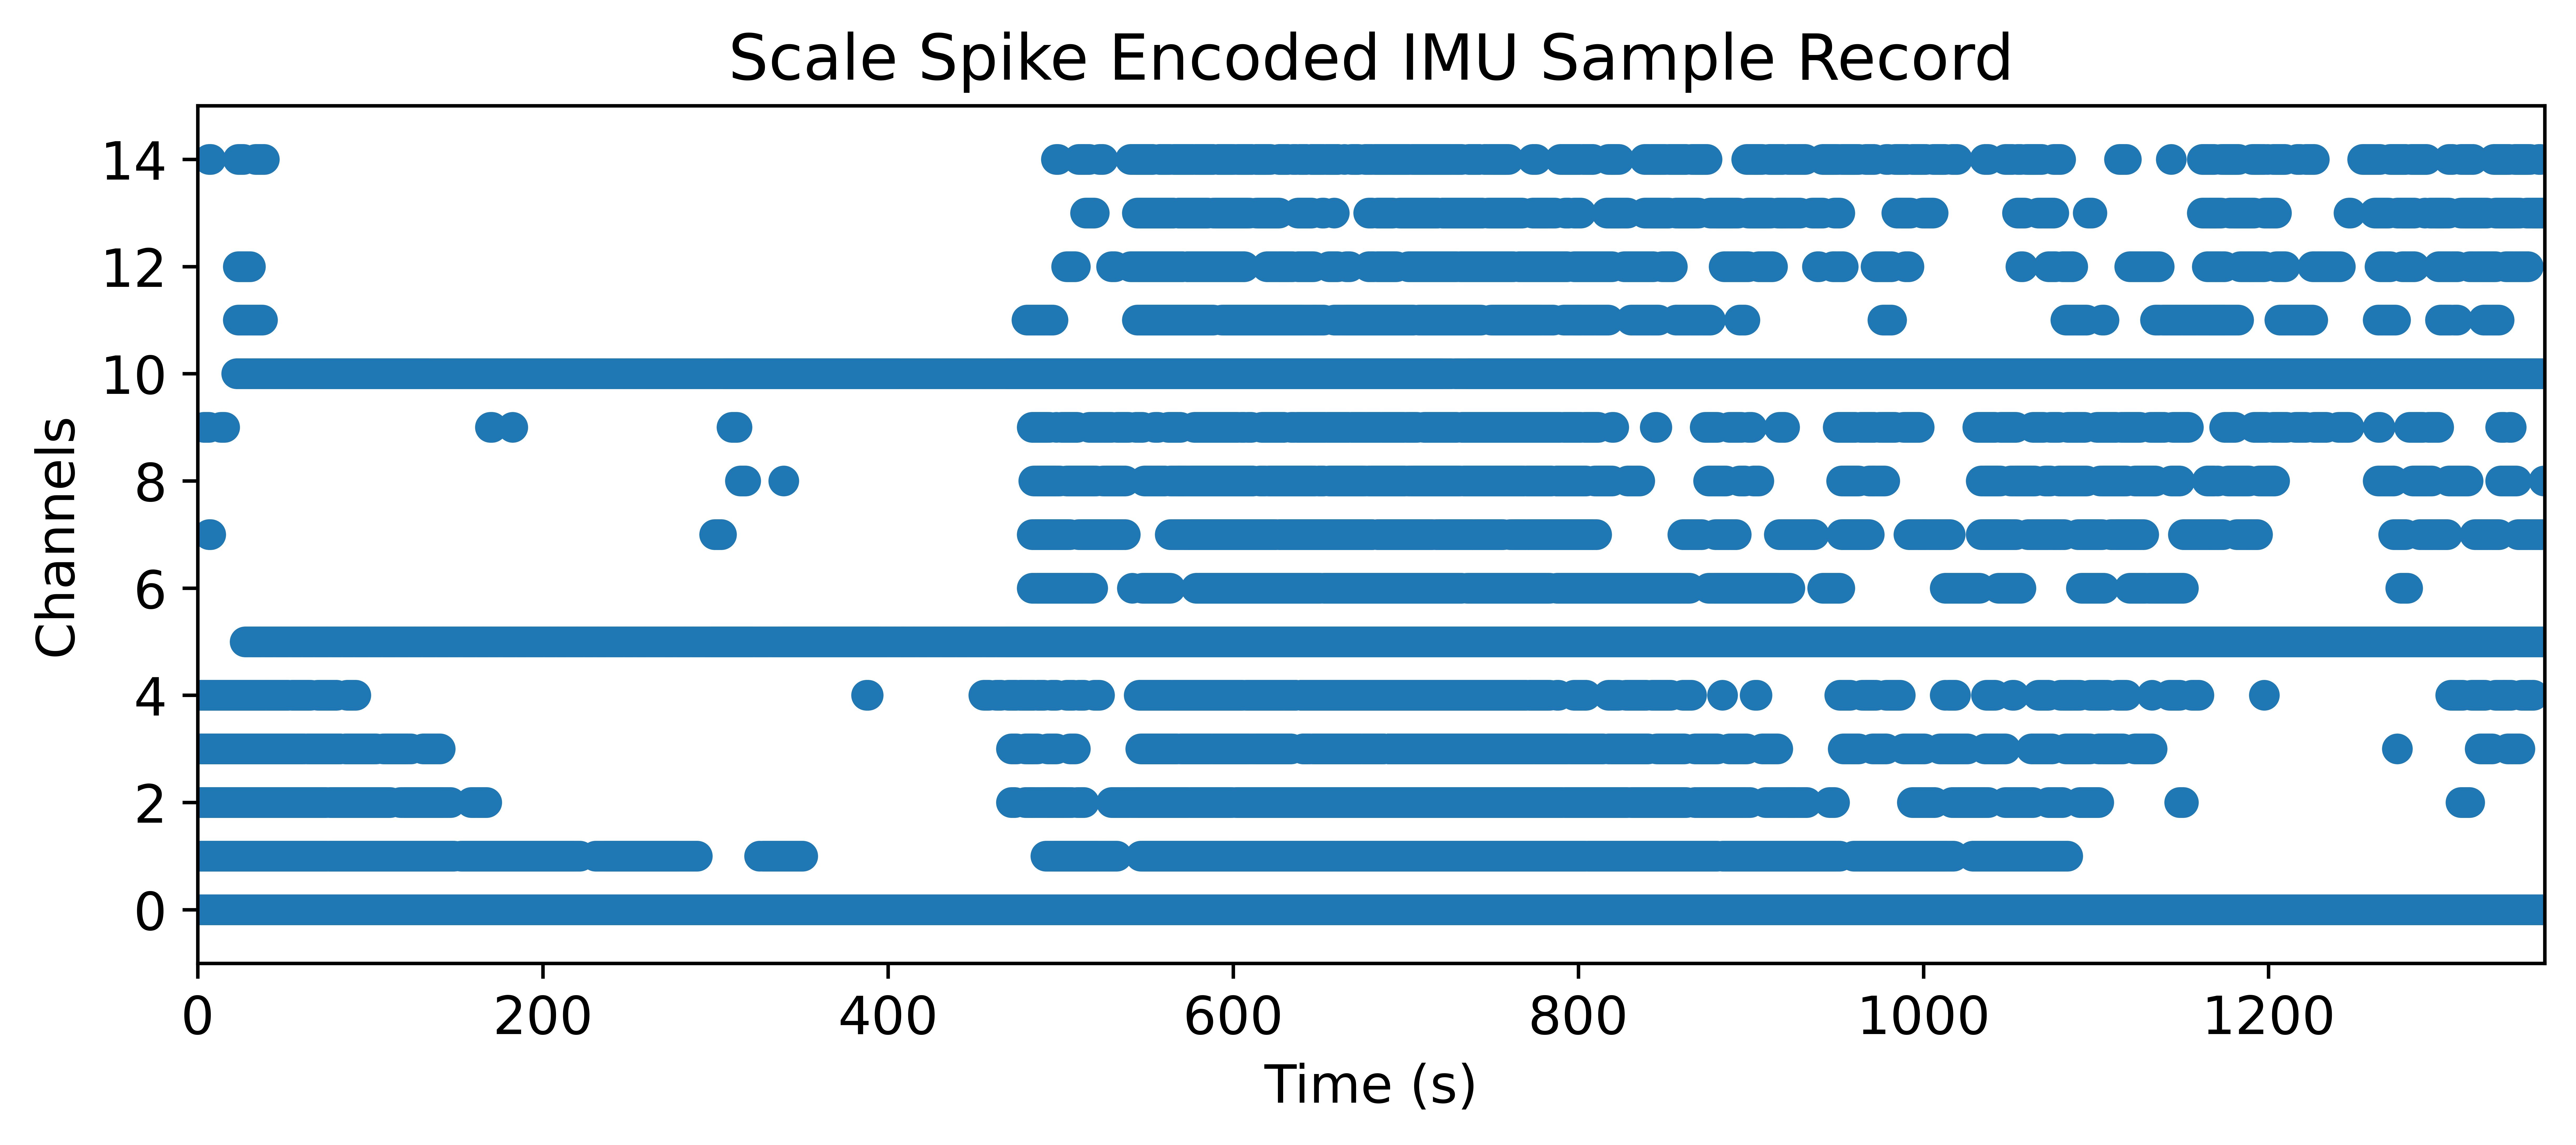

In [33]:
plt.figure()
TSEvent.from_raster(scaled[0]).plot()
plt.title(f"Scale Spike Encoded IMU Sample Record")
plt.show()


In [34]:
iaf_encoder = IAFSpikeEncoder(threshold=1600)
iaf_spikes, _, _ = iaf_encoder(filtered)
iaf_spikes.shape


(1, 1360, 15)

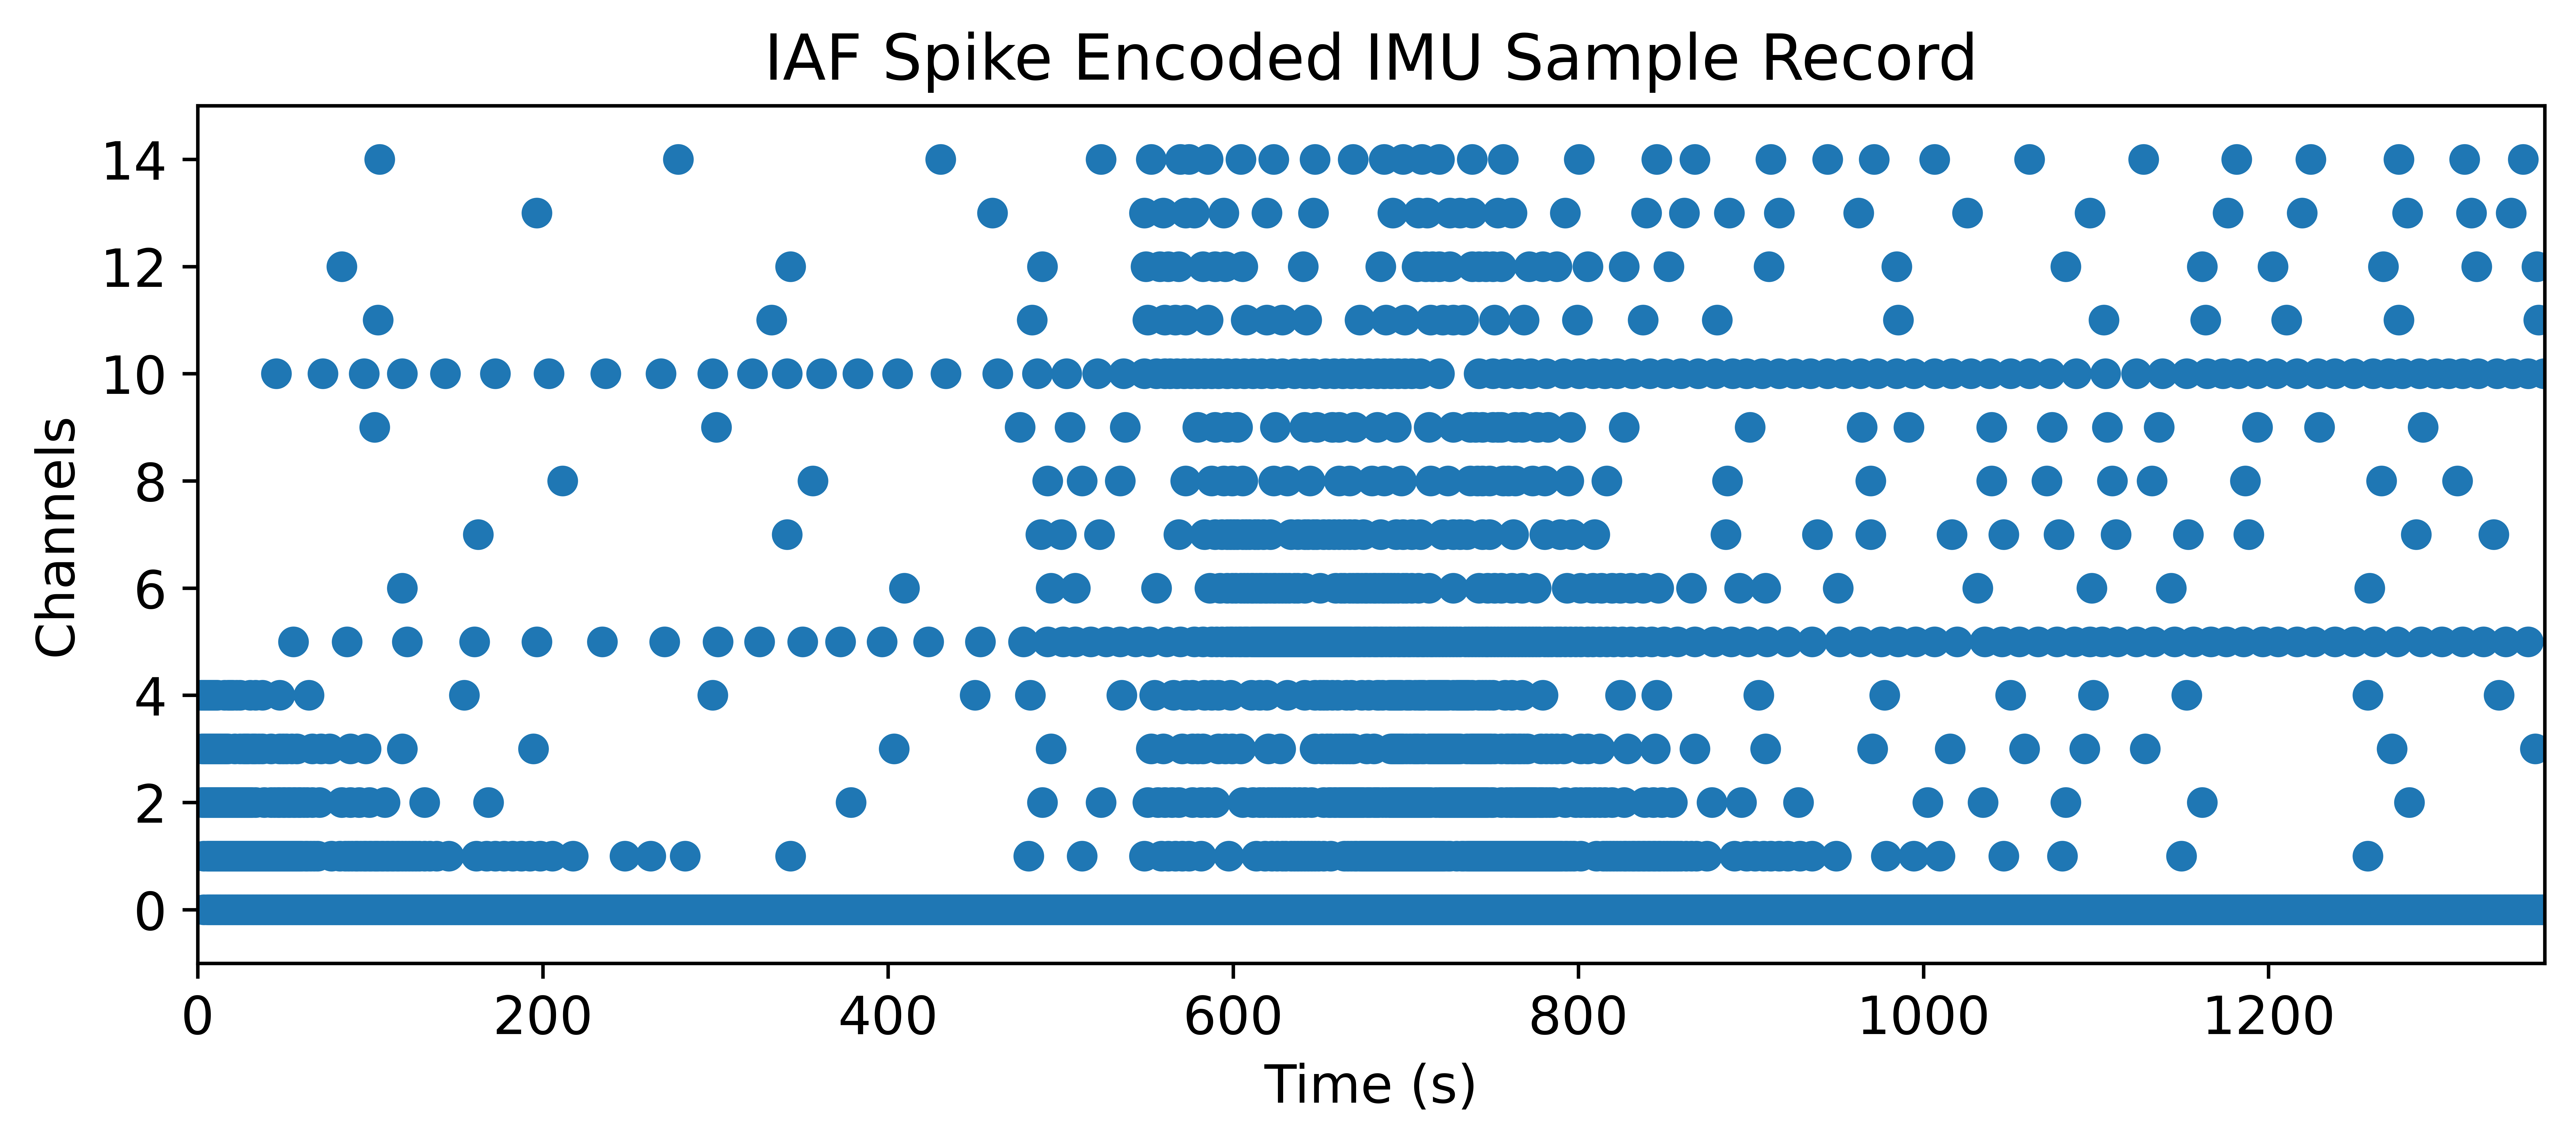

In [35]:
plt.figure()
TSEvent.from_raster(iaf_spikes[0]).plot()
plt.title(f"IAF Spike Encoded IMU Sample Record")
plt.show()


## Final : Combine All

In [36]:
mod_IMUIF = Sequential(
    Quantizer(scale=0.49, num_bits=num_bits_in),
    RotationRemoval(
        num_avg_bitshift=num_avg_bitshift,
        sampling_period=sampling_period,
    ),
    FilterBank(),
    ScaleSpikeEncoder(),
)
mod_IMUIF


ModSequential  with shape (3, 15) {
    Quantizer '0_Quantizer' with shape (3, 3)
    RotationRemoval '1_RotationRemoval' with shape (3, 3) {
        ModSequential 'sub_estimate' with shape (3, 9) {
            SubSpace '0_SubSpace' with shape (3, 9)
            SampleAndHold '1_SampleAndHold' with shape (9, 9)
        }
    }
    FilterBank '2_FilterBank' with shape (3, 15)
    ScaleSpikeEncoder '3_ScaleSpikeEncoder' with shape (15, 15)
}

In [37]:
result, _, _ = mod_IMUIF(data)
result.shape


(1, 1360, 15)

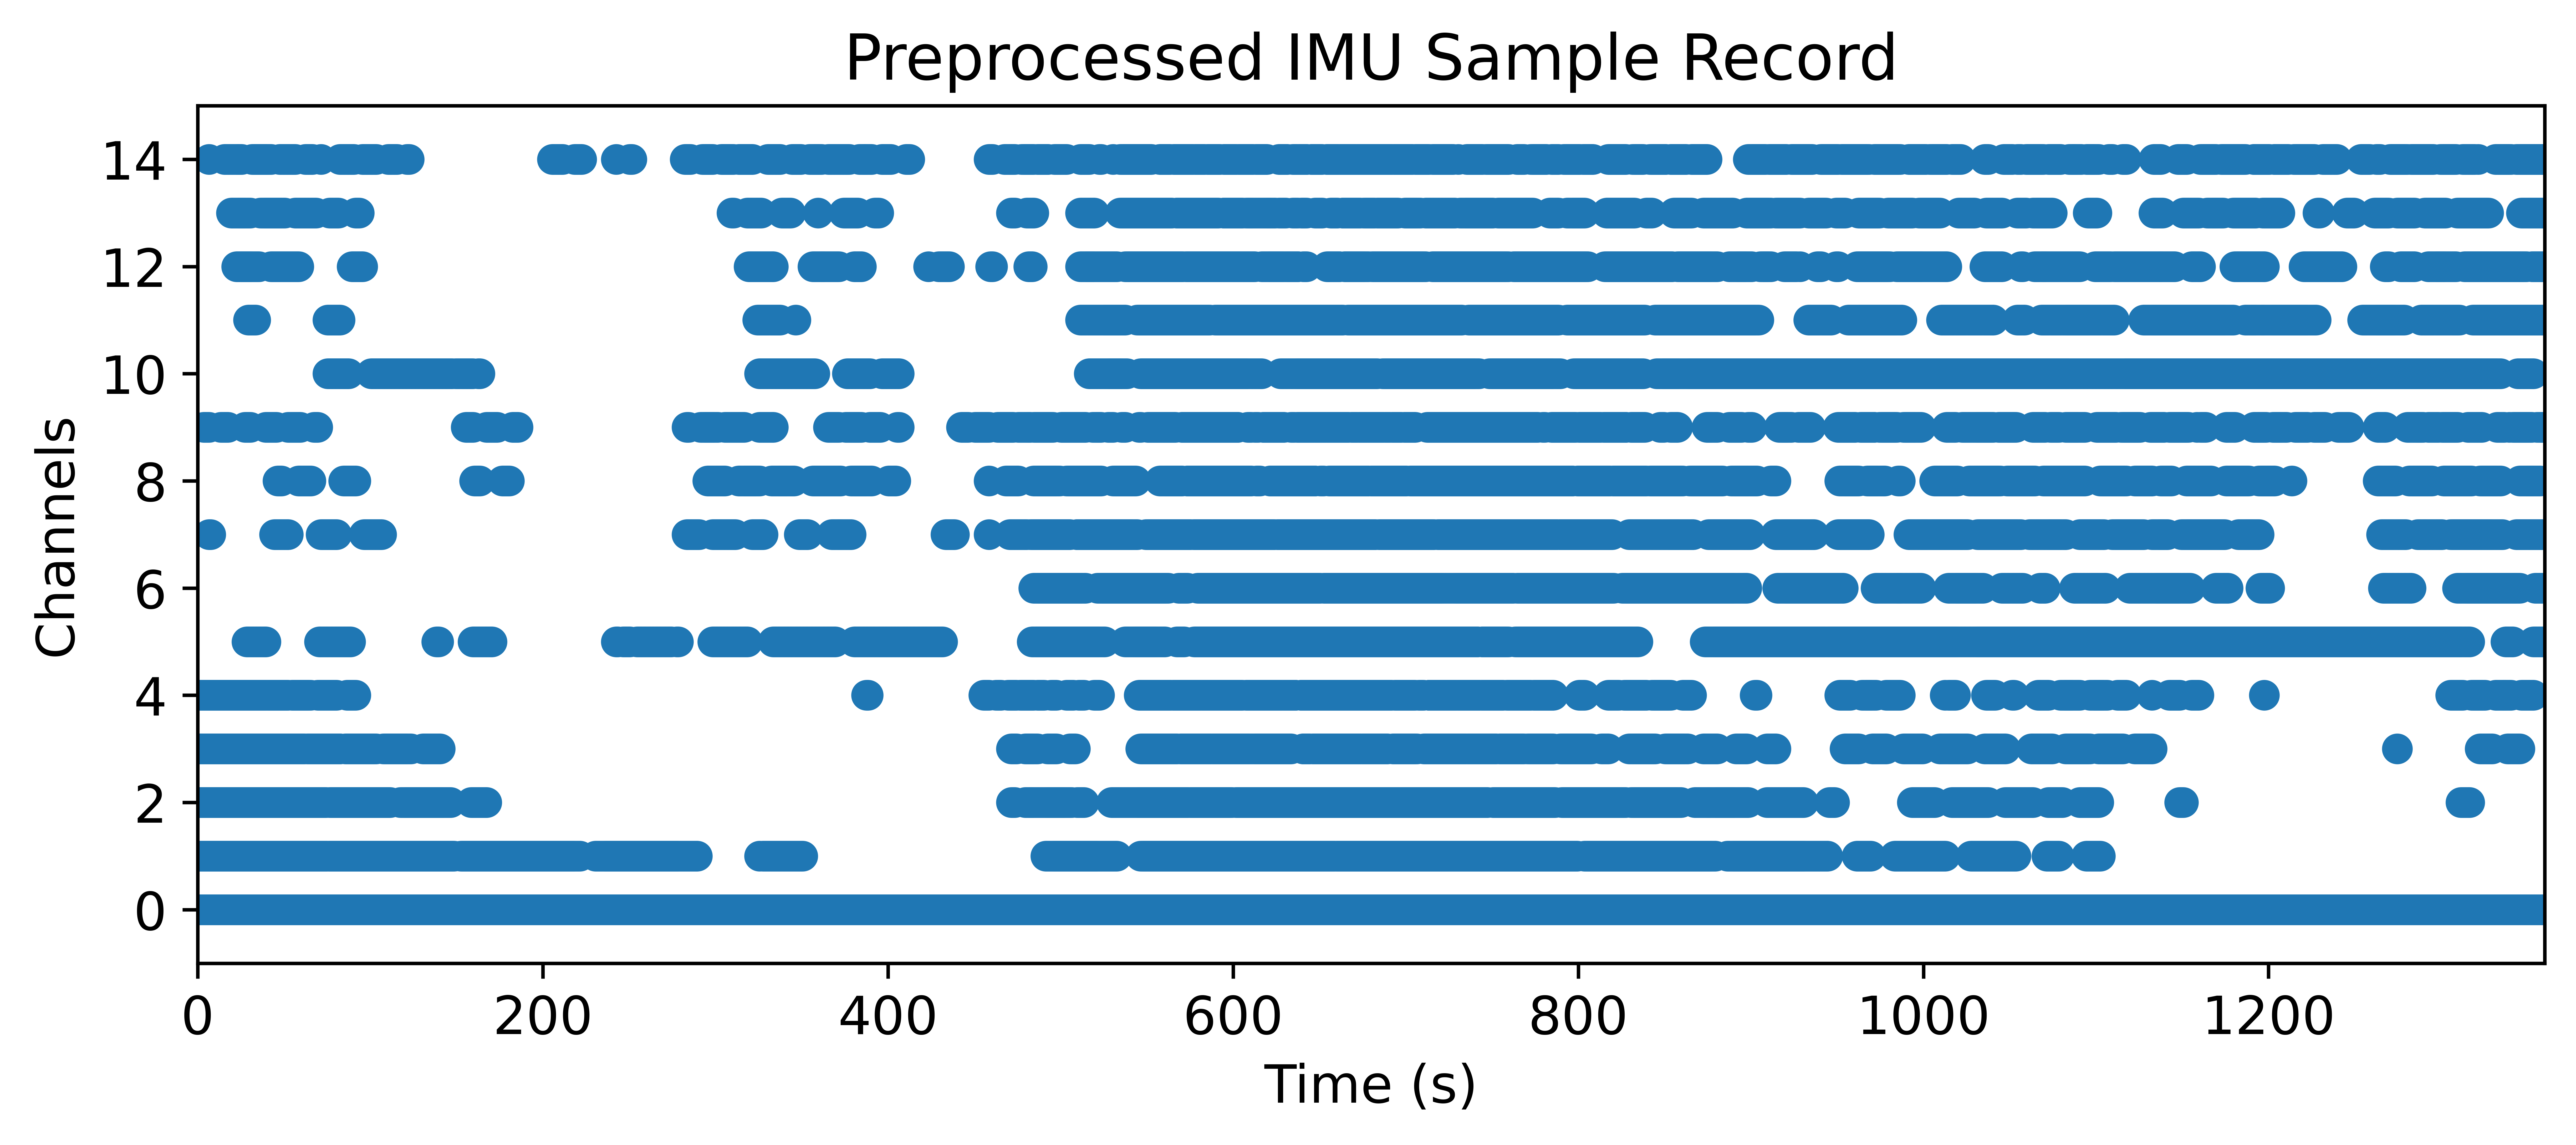

In [38]:
plt.figure()
TSEvent.from_raster(result[0]).plot()
plt.title(f"Preprocessed IMU Sample Record")
plt.show()
